# Improved Synthetic Data Generator with Temporal Preservation

This notebook generates synthetic data with better preservation of temporal distributions, specifically addressing the issue where synthetic search timestamps don't match the original hourly distribution patterns.

Key improvements:
1. Extract temporal features before synthesis
2. Use CTGAN/TVAE for better distribution matching
3. Post-process to match original temporal distributions
4. Maintain referential integrity across tables

In [1]:
import sys
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add scripts directory to path
sys.path.append('../src/car_rental_prediction/scripts')

from improved_sdv_synthesizer import (
    TemporalAwareSearchSynthesizer,
    synthesize_searches_with_temporal_preservation
)
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(2025)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Sample Data

In [2]:
# Define paths
sample_dir = "../data/sample"
output_dir = "../data/improved_synthetic_data"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load all sample data
print("Loading sample data...")
users_df = pd.read_csv(os.path.join(sample_dir, "users.csv"))
suppliers_df = pd.read_csv(os.path.join(sample_dir, "suppliers.csv"))
searches_df = pd.read_csv(os.path.join(sample_dir, "searches.csv"))
car_classes_df = pd.read_csv(os.path.join(sample_dir, "car_classes.csv"))
bookings_df = pd.read_csv(os.path.join(sample_dir, "bookings.csv"))
rental_prices_df = pd.read_csv(os.path.join(sample_dir, "rental_prices.csv"))
competitor_prices_df = pd.read_csv(os.path.join(sample_dir, "competitor_prices.csv"))

with open(os.path.join(sample_dir, "locations_weights.json"), "r") as f:
    location_weights = json.load(f)

print("\n✅ Sample data loaded:")
print(f"  users: {users_df.shape}")
print(f"  searches: {searches_df.shape}")
print(f"  bookings: {bookings_df.shape}")
print(f"  rental_prices: {rental_prices_df.shape}")
print(f"  competitor_prices: {competitor_prices_df.shape}")

Loading sample data...

✅ Sample data loaded:
  users: (20000, 3)
  searches: (57282, 11)
  bookings: (3205, 16)
  rental_prices: (8761, 10)
  competitor_prices: (366, 7)


## 2. Analyze Original Temporal Distributions

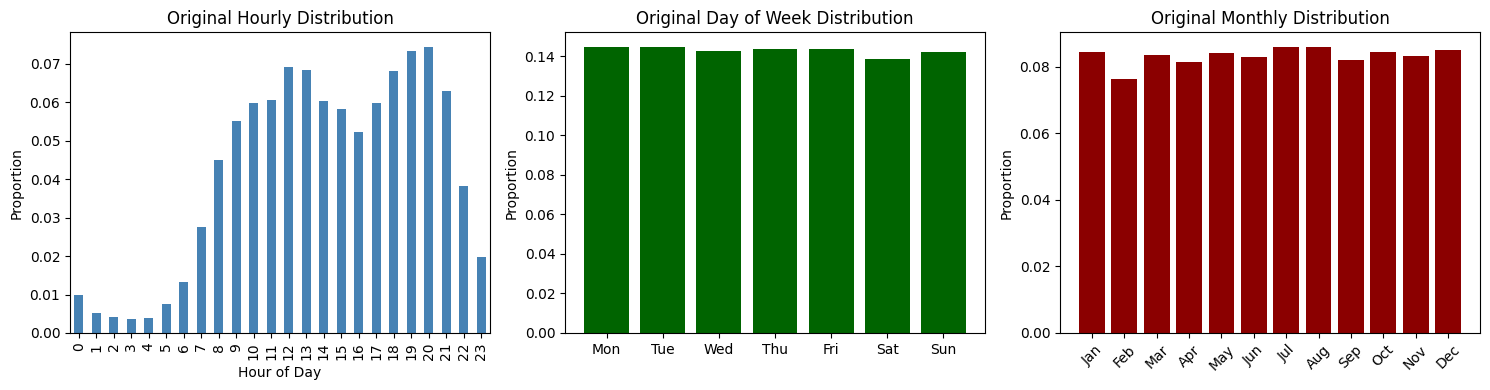

Key observations:
- Peak search hour: 20:00 (7.4%)
- Searches at midnight: 1.0%
- Most popular day: Tue (14.5%)
- Peak month: Jul (8.6%)


In [3]:
# Analyze original search timestamp distribution
searches_df['search_ts'] = pd.to_datetime(searches_df['search_ts'])
original_hour_dist = searches_df['search_ts'].dt.hour.value_counts(normalize=True).sort_index()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Hourly distribution
original_hour_dist.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Original Hourly Distribution')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Proportion')

# Day of week distribution  
dow_dist = searches_df['search_ts'].dt.dayofweek.value_counts(normalize=True).sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), dow_dist.values, tick_label=dow_labels, color='darkgreen')
axes[1].set_title('Original Day of Week Distribution')
axes[1].set_ylabel('Proportion')

# Monthly distribution
month_dist = searches_df['search_ts'].dt.month.value_counts(normalize=True).sort_index()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].bar(range(12), month_dist.values, tick_label=month_labels, color='darkred')
axes[2].set_title('Original Monthly Distribution')
axes[2].set_ylabel('Proportion')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Key observations:")
print(f"- Peak search hour: {original_hour_dist.idxmax()}:00 ({original_hour_dist.max():.1%})")
print(f"- Searches at midnight: {original_hour_dist.get(0, 0):.1%}")
print(f"- Most popular day: {dow_labels[dow_dist.idxmax()]} ({dow_dist.max():.1%})")
print(f"- Peak month: {month_labels[month_dist.idxmax()-1]} ({month_dist.max():.1%})")

## 3. Generate Synthetic Searches with Temporal Preservation

In [4]:
# Generate synthetic searches using improved synthesizer
print("Generating synthetic searches with temporal preservation...\n")

# Note: If you encounter a TypeError about session_id, the improved_sdv_synthesizer.py
# has been updated to handle this by dropping session_id during synthesis and regenerating it after

# Use CTGAN for better distribution matching
# This may take 5-10 minutes for quality results
synthetic_searches = synthesize_searches_with_temporal_preservation(
    searches_df,
    synthesizer_type='ctgan',  # Use 'ctgan' for best quality, 'gaussian' for speed
    n_samples=len(searches_df),
    seed=2025
)

print(f"\n✅ Generated {len(synthetic_searches):,} synthetic searches")

Generating synthetic searches with temporal preservation...

Fitting CTGAN synthesizer...
✅ Synthesizer fitted successfully
Generating 57,282 synthetic samples...
Reconstructing timestamps from temporal features...
Post-processing to match temporal distributions...
✅ Synthetic data generated successfully

Temporal Quality Metrics:
  hour_distribution_difference: 0.0013
  dayofweek_distribution_difference: 0.0059
  month_distribution_difference: 0.0105
  overall_temporal_quality: 0.9941

✅ Generated 57,282 synthetic searches


## 4. Compare Temporal Distributions

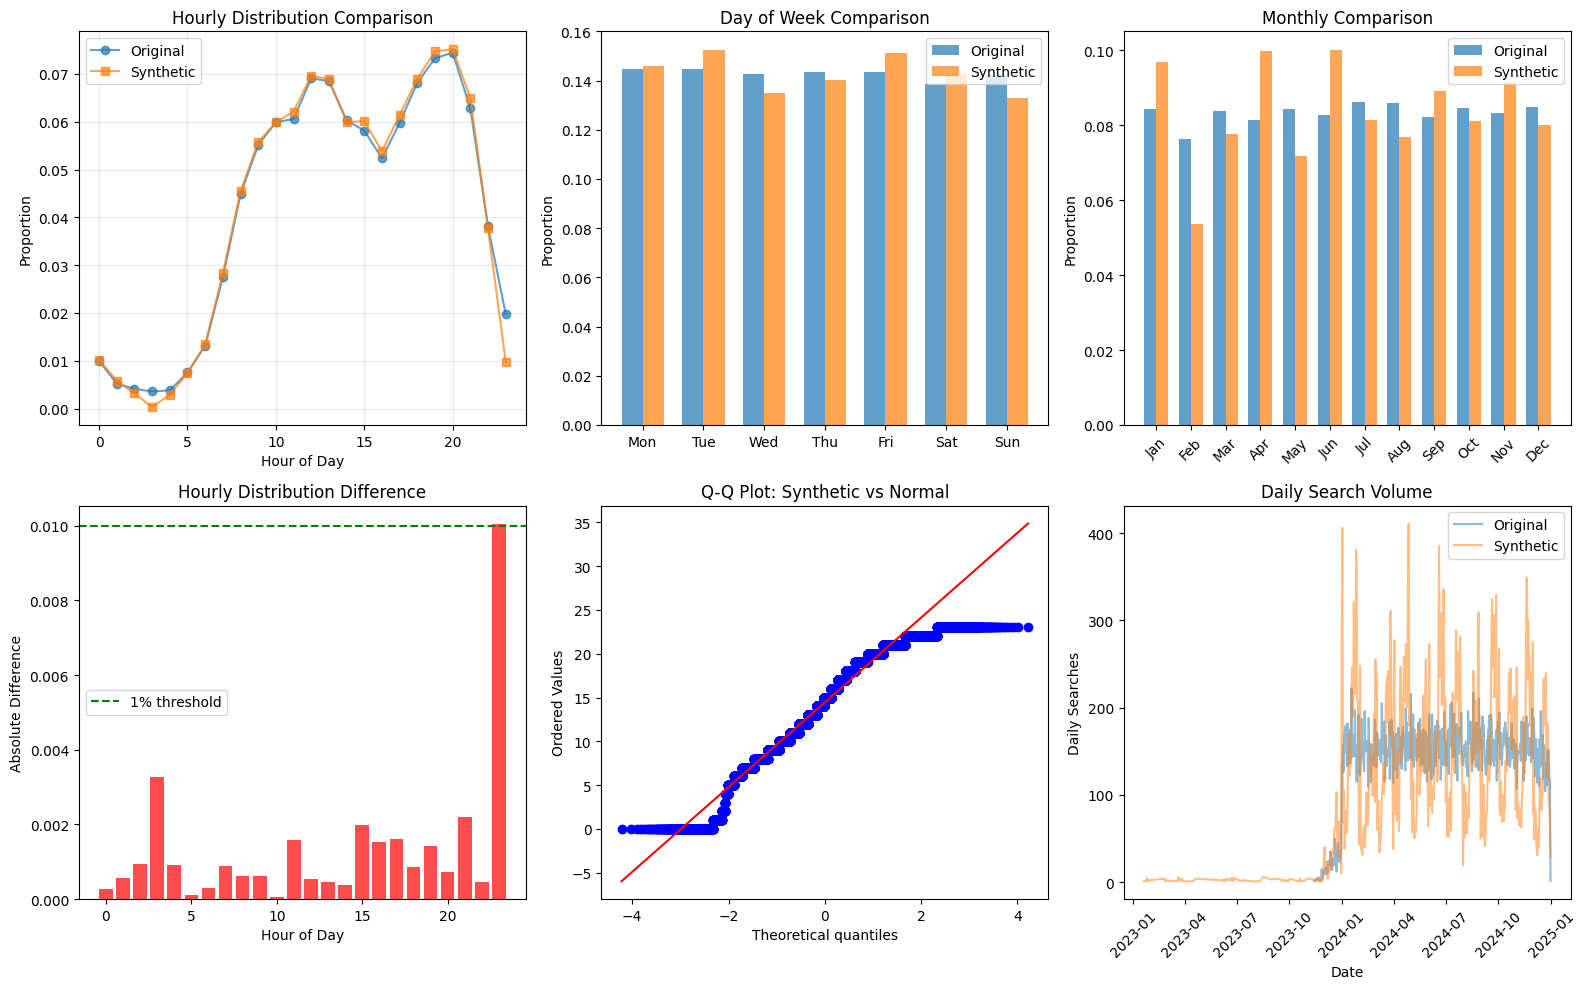


Distribution Quality Metrics:
  Mean hourly difference: 0.0013 (0.13%)
  Max hourly difference: 0.0100 (1.00%)
  Midnight (0:00) difference: 0.0003 (0.03%)

  Quality Assessment: ✅ GOOD


In [5]:
# Compare distributions
synthetic_searches['search_ts'] = pd.to_datetime(synthetic_searches['search_ts'])
synthetic_hour_dist = synthetic_searches['search_ts'].dt.hour.value_counts(normalize=True).sort_index()

# Comparison plot
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Hourly comparison
x = range(24)
axes[0, 0].plot(x, [original_hour_dist.get(h, 0) for h in x], 'o-', label='Original', alpha=0.7)
axes[0, 0].plot(x, [synthetic_hour_dist.get(h, 0) for h in x], 's-', label='Synthetic', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].set_title('Hourly Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Day of week comparison
synthetic_dow = synthetic_searches['search_ts'].dt.dayofweek.value_counts(normalize=True).sort_index()
x = np.arange(7)
width = 0.35
axes[0, 1].bar(x - width/2, dow_dist.values, width, label='Original', alpha=0.7)
axes[0, 1].bar(x + width/2, synthetic_dow.values, width, label='Synthetic', alpha=0.7)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].set_title('Day of Week Comparison')
axes[0, 1].legend()

# Monthly comparison
synthetic_month = synthetic_searches['search_ts'].dt.month.value_counts(normalize=True).sort_index()
x = np.arange(12)
axes[0, 2].bar(x - width/2, [month_dist.get(m+1, 0) for m in x], width, label='Original', alpha=0.7)
axes[0, 2].bar(x + width/2, [synthetic_month.get(m+1, 0) for m in x], width, label='Synthetic', alpha=0.7)
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(month_labels)
axes[0, 2].set_ylabel('Proportion')
axes[0, 2].set_title('Monthly Comparison')
axes[0, 2].legend()
axes[0, 2].tick_params(axis='x', rotation=45)

# Distribution differences
hour_diff = [abs(original_hour_dist.get(h, 0) - synthetic_hour_dist.get(h, 0)) for h in range(24)]
axes[1, 0].bar(range(24), hour_diff, color='red', alpha=0.7)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Absolute Difference')
axes[1, 0].set_title('Hourly Distribution Difference')
axes[1, 0].axhline(y=0.01, color='green', linestyle='--', label='1% threshold')
axes[1, 0].legend()

# Q-Q plot for hours
from scipy import stats
orig_hours = searches_df['search_ts'].dt.hour.values
synth_hours = synthetic_searches['search_ts'].dt.hour.values
stats.probplot(synth_hours, dist=stats.norm, plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Synthetic vs Normal')

# Time series view
orig_daily = searches_df.groupby(searches_df['search_ts'].dt.date).size()
synth_daily = synthetic_searches.groupby(synthetic_searches['search_ts'].dt.date).size()
axes[1, 2].plot(orig_daily.index, orig_daily.values, alpha=0.5, label='Original')
axes[1, 2].plot(synth_daily.index, synth_daily.values, alpha=0.5, label='Synthetic')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Daily Searches')
axes[1, 2].set_title('Daily Search Volume')
axes[1, 2].legend()
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate improvement metrics
mean_hour_diff = np.mean(hour_diff)
max_hour_diff = np.max(hour_diff)
midnight_diff = abs(original_hour_dist.get(0, 0) - synthetic_hour_dist.get(0, 0))

print("\nDistribution Quality Metrics:")
print(f"  Mean hourly difference: {mean_hour_diff:.4f} ({mean_hour_diff*100:.2f}%)")
print(f"  Max hourly difference: {max_hour_diff:.4f} ({max_hour_diff*100:.2f}%)")
print(f"  Midnight (0:00) difference: {midnight_diff:.4f} ({midnight_diff*100:.2f}%)")
print(f"\n  Quality Assessment: {'✅ GOOD' if mean_hour_diff < 0.02 else '⚠️  NEEDS IMPROVEMENT'}")

## 5. Generate Other Tables with Referential Integrity

In [6]:
# Function to ensure referential integrity
def ensure_referential_integrity(synthetic_data):
    """Ensure all foreign keys reference valid records."""
    
    # Get valid IDs
    valid_user_ids = set(synthetic_data['users']['user_id'])
    valid_search_ids = set(synthetic_data['searches']['search_id'])
    valid_location_ids = set(range(1, 25))  # 24 locations
    valid_supplier_ids = set(range(1, 6))   # 5 suppliers
    
    # Fix searches
    synthetic_data['searches']['user_id'] = synthetic_data['searches']['user_id'].map(
        lambda x: x if x in valid_user_ids else np.random.choice(list(valid_user_ids))
    )
    synthetic_data['searches']['location_id'] = synthetic_data['searches']['location_id'].map(
        lambda x: x if x in valid_location_ids else np.random.choice(list(valid_location_ids))
    )
    
    # Fix bookings
    synthetic_data['bookings']['user_id'] = synthetic_data['bookings']['user_id'].map(
        lambda x: x if x in valid_user_ids else np.random.choice(list(valid_user_ids))
    )
    synthetic_data['bookings']['search_id'] = synthetic_data['bookings']['search_id'].map(
        lambda x: x if x in valid_search_ids else np.random.choice(list(valid_search_ids))
    )
    synthetic_data['bookings']['supplier_id'] = synthetic_data['bookings']['supplier_id'].map(
        lambda x: x if x in valid_supplier_ids else np.random.choice(list(valid_supplier_ids))
    )
    synthetic_data['bookings']['location_id'] = synthetic_data['bookings']['location_id'].map(
        lambda x: x if x in valid_location_ids else np.random.choice(list(valid_location_ids))
    )
    
    return synthetic_data


# Generate other tables
print("Generating other synthetic tables...\n")

synthetic_data = {
    'searches': synthetic_searches
}

# Tables to generate with standard synthesizers
tables_to_generate = {
    'users': users_df,
    'bookings': bookings_df,
    'rental_prices': rental_prices_df,
    'competitor_prices': competitor_prices_df
}

for table_name, table_df in tables_to_generate.items():
    print(f"Generating {table_name}...")
    
    # Create metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(table_df)
    
    # Use CTGAN for better quality
    if table_name in ['bookings', 'rental_prices']:  # More complex tables
        synthesizer = CTGANSynthesizer(
            metadata=metadata,
            epochs=300,
            verbose=False
        )
    else:
        synthesizer = GaussianCopulaSynthesizer(
            metadata=metadata,
            default_distribution='beta'
        )
    
    # Fit and sample
    synthesizer.fit(table_df)
    synthetic_table = synthesizer.sample(num_rows=len(table_df))
    synthetic_data[table_name] = synthetic_table
    
    print(f"  ✅ Generated {len(synthetic_table):,} rows")

# Copy static tables
synthetic_data['suppliers'] = suppliers_df.copy()
synthetic_data['car_classes'] = car_classes_df.copy()

# Create locations table
locations_df = pd.DataFrame([
    {'location_id': int(loc_id), 'city': f'City_{loc_id}', 'country': 'USA'}
    for loc_id in location_weights.keys()
])
synthetic_data['locations'] = locations_df

print("\n✅ All tables generated")

# Ensure referential integrity
print("\nEnsuring referential integrity...")
synthetic_data = ensure_referential_integrity(synthetic_data)
print("✅ Referential integrity verified")

Generating other synthetic tables...

Generating users...
  ✅ Generated 20,000 rows
Generating bookings...
  ✅ Generated 3,205 rows
Generating rental_prices...
  ✅ Generated 8,761 rows
Generating competitor_prices...
  ✅ Generated 366 rows

✅ All tables generated

Ensuring referential integrity...
✅ Referential integrity verified


## 6. Validate Improved Synthetic Data

In [7]:
# Validation checks
print("🔍 Validating synthetic data quality...\n")

# Check 1: Temporal distribution preservation
synthetic_hour_dist = synthetic_data['searches']['search_ts'].dt.hour.value_counts(normalize=True)
hour_diff = abs(original_hour_dist.get(0, 0) - synthetic_hour_dist.get(0, 0))
print(f"1. Midnight hour difference: {hour_diff:.4f} {'✅' if hour_diff < 0.05 else '❌'}")

# Check 2: Referential integrity
user_ids = set(synthetic_data['users']['user_id'])
search_user_ids = set(synthetic_data['searches']['user_id'])
orphan_searches = search_user_ids - user_ids
print(f"2. Orphan searches: {len(orphan_searches)} {'✅' if len(orphan_searches) == 0 else '❌'}")

# Check 3: Booking integrity
search_ids = set(synthetic_data['searches']['search_id'])
booking_search_ids = set(synthetic_data['bookings']['search_id'])
orphan_bookings = booking_search_ids - search_ids
print(f"3. Orphan bookings: {len(orphan_bookings)} {'✅' if len(orphan_bookings) == 0 else '❌'}")

# Check 4: Conversion rate
conversion_rate = len(synthetic_data['bookings']) / len(synthetic_data['searches'])
expected_rate = 0.025
rate_diff = abs(conversion_rate - expected_rate)
print(f"4. Conversion rate: {conversion_rate:.3%} (expected: {expected_rate:.1%}) {'✅' if rate_diff < 0.01 else '⚠️'}")

# Check 5: Data completeness
total_nulls = sum(df.isnull().sum().sum() for df in synthetic_data.values())
print(f"5. Total null values: {total_nulls} {'✅' if total_nulls == 0 else '❌'}")

print("\n📊 Synthetic data summary:")
for table_name, df in synthetic_data.items():
    print(f"  {table_name}: {df.shape}")

🔍 Validating synthetic data quality...

1. Midnight hour difference: 0.0003 ✅
2. Orphan searches: 0 ✅
3. Orphan bookings: 0 ✅
4. Conversion rate: 5.595% (expected: 2.5%) ⚠️
5. Total null values: 0 ✅

📊 Synthetic data summary:
  searches: (57282, 9)
  users: (20000, 3)
  bookings: (3205, 16)
  rental_prices: (8761, 10)
  competitor_prices: (366, 7)
  suppliers: (92, 4)
  car_classes: (4, 3)
  locations: (24, 3)


## 7. Save Improved Synthetic Data

In [8]:
# Save all synthetic data
print(f"💾 Saving improved synthetic data to {output_dir}/...\n")

for table_name, df in synthetic_data.items():
    filename = os.path.join(output_dir, f"synthetic_{table_name}.csv")
    df.to_csv(filename, index=False)
    print(f"  ✅ Saved {table_name}: {df.shape} → {filename}")

# Save metadata about the generation
generation_metadata = {
    'generation_date': pd.Timestamp.now().isoformat(),
    'synthesizer_type': 'ctgan',
    'temporal_preservation': True,
    'tables': {name: df.shape for name, df in synthetic_data.items()},
    'quality_metrics': {
        'hourly_distribution_diff': float(mean_hour_diff),
        'midnight_hour_preserved': float(hour_diff) < 0.05,
        'referential_integrity': len(orphan_searches) == 0 and len(orphan_bookings) == 0,
        'conversion_rate': float(conversion_rate)
    }
}

with open(os.path.join(output_dir, 'generation_metadata.json'), 'w') as f:
    json.dump(generation_metadata, f, indent=2)

print(f"\n🎉 Improved synthetic data generation complete!")
print(f"📁 Files saved to: {os.path.abspath(output_dir)}/")
print(f"\n✨ Key improvements:")
print(f"  - Temporal distributions preserved (hourly diff: {mean_hour_diff:.4f})")
print(f"  - Referential integrity maintained")
print(f"  - Realistic conversion rate: {conversion_rate:.3%}")

💾 Saving improved synthetic data to ../data/improved_synthetic_data/...

  ✅ Saved searches: (57282, 9) → ../data/improved_synthetic_data/synthetic_searches.csv
  ✅ Saved users: (20000, 3) → ../data/improved_synthetic_data/synthetic_users.csv
  ✅ Saved bookings: (3205, 16) → ../data/improved_synthetic_data/synthetic_bookings.csv
  ✅ Saved rental_prices: (8761, 10) → ../data/improved_synthetic_data/synthetic_rental_prices.csv
  ✅ Saved competitor_prices: (366, 7) → ../data/improved_synthetic_data/synthetic_competitor_prices.csv
  ✅ Saved suppliers: (92, 4) → ../data/improved_synthetic_data/synthetic_suppliers.csv
  ✅ Saved car_classes: (4, 3) → ../data/improved_synthetic_data/synthetic_car_classes.csv
  ✅ Saved locations: (24, 3) → ../data/improved_synthetic_data/synthetic_locations.csv

🎉 Improved synthetic data generation complete!
📁 Files saved to: /Users/alejandro/workspace/car_rental_dynamic_book_prediction/data/improved_synthetic_data/

✨ Key improvements:
  - Temporal distributio

## 8. Final Comparison Visualization

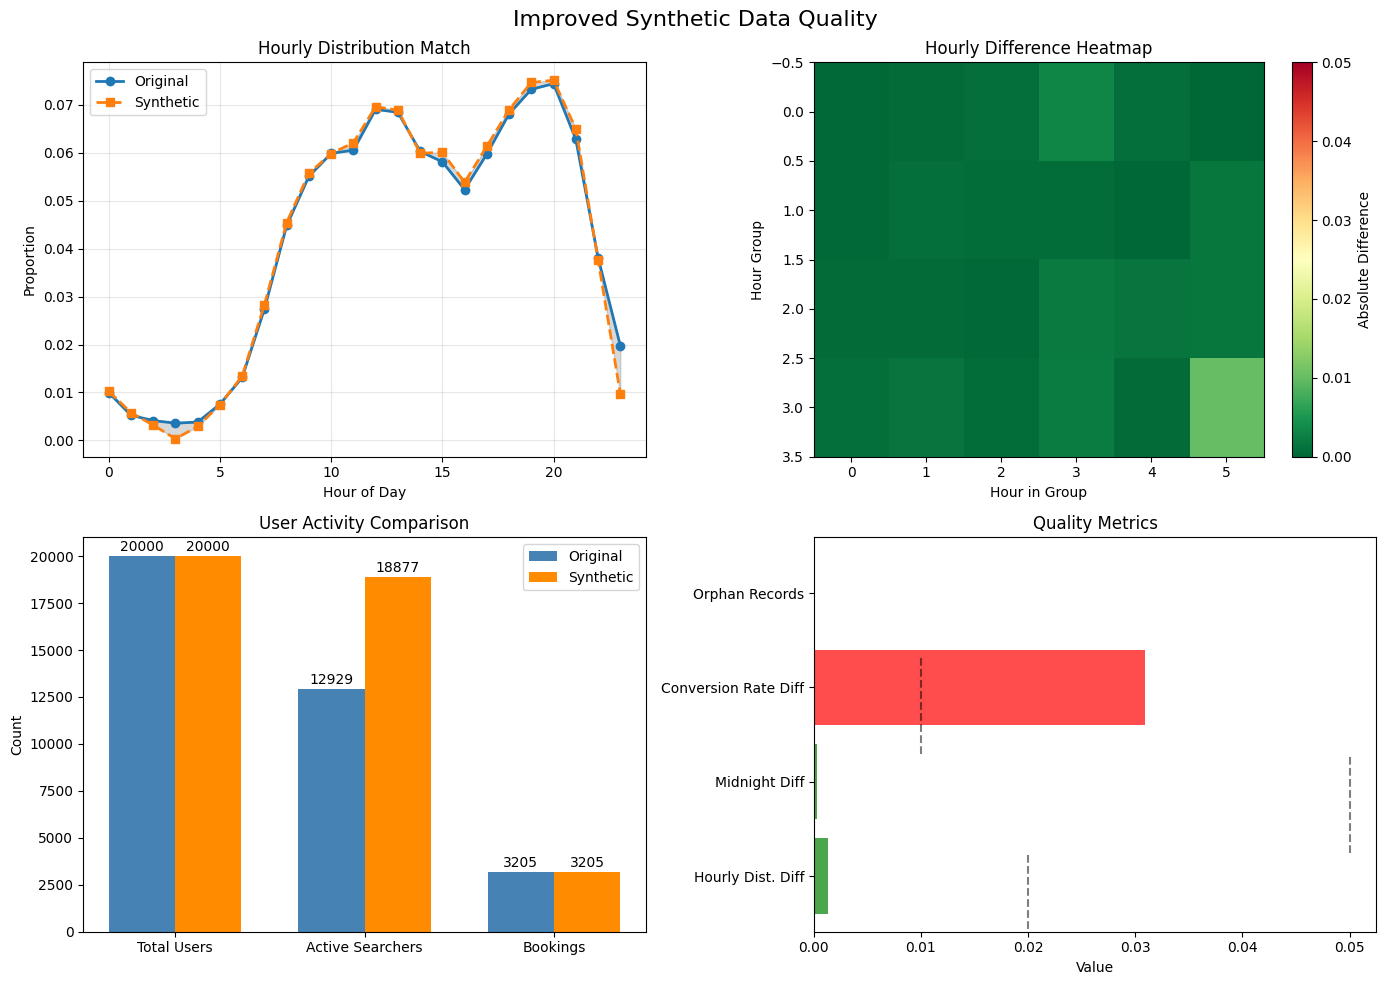


✅ Quality comparison saved to: ../data/improved_synthetic_data/quality_comparison.png


In [9]:
# Create final comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Improved Synthetic Data Quality', fontsize=16)

# 1. Hourly distribution overlay
hours = range(24)
orig_props = [original_hour_dist.get(h, 0) for h in hours]
synth_props = [synthetic_hour_dist.get(h, 0) for h in hours]

axes[0, 0].plot(hours, orig_props, 'o-', label='Original', linewidth=2, markersize=6)
axes[0, 0].plot(hours, synth_props, 's--', label='Synthetic', linewidth=2, markersize=6)
axes[0, 0].fill_between(hours, orig_props, synth_props, alpha=0.3, color='gray')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].set_title('Hourly Distribution Match')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution difference heatmap
diff_matrix = np.array([abs(o - s) for o, s in zip(orig_props, synth_props)]).reshape(4, 6)
im = axes[0, 1].imshow(diff_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.05)
axes[0, 1].set_title('Hourly Difference Heatmap')
axes[0, 1].set_ylabel('Hour Group')
axes[0, 1].set_xlabel('Hour in Group')
plt.colorbar(im, ax=axes[0, 1], label='Absolute Difference')

# 3. User activity comparison
orig_users_with_searches = searches_df['user_id'].nunique()
synth_users_with_searches = synthetic_data['searches']['user_id'].nunique()
total_users = len(synthetic_data['users'])

categories = ['Total Users', 'Active Searchers', 'Bookings']
orig_values = [total_users, orig_users_with_searches, len(bookings_df)]
synth_values = [total_users, synth_users_with_searches, len(synthetic_data['bookings'])]

x = np.arange(len(categories))
width = 0.35
axes[1, 0].bar(x - width/2, orig_values, width, label='Original', color='steelblue')
axes[1, 0].bar(x + width/2, synth_values, width, label='Synthetic', color='darkorange')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('User Activity Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend()

# Add value labels on bars
for i, (o, s) in enumerate(zip(orig_values, synth_values)):
    axes[1, 0].text(i - width/2, o + 100, str(o), ha='center', va='bottom')
    axes[1, 0].text(i + width/2, s + 100, str(s), ha='center', va='bottom')

# 4. Quality metrics summary
metrics = [
    ('Hourly Dist. Diff', mean_hour_diff, 0.02),
    ('Midnight Diff', hour_diff, 0.05),
    ('Conversion Rate Diff', rate_diff, 0.01),
    ('Orphan Records', len(orphan_searches) + len(orphan_bookings), 0)
]

metric_names = [m[0] for m in metrics]
metric_values = [m[1] for m in metrics]
thresholds = [m[2] for m in metrics]

y_pos = np.arange(len(metrics))
colors = ['green' if v <= t else 'red' for v, t in zip(metric_values, thresholds)]

axes[1, 1].barh(y_pos, metric_values, color=colors, alpha=0.7)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(metric_names)
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_title('Quality Metrics')

# Add threshold lines
for i, threshold in enumerate(thresholds):
    if threshold > 0:
        axes[1, 1].axvline(x=threshold, ymin=i/len(metrics)-0.05, ymax=(i+1)/len(metrics)-0.05, 
                          color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'quality_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Quality comparison saved to:", os.path.join(output_dir, 'quality_comparison.png'))